In [120]:
# 标准起手式
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.io as sio
import re
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from tpot import TPOTRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

In [87]:
ori_data = pd.read_csv('2025_Problem_C_Data/SportEventsSum.csv')
host_mp = pd.read_csv('2025_Problem_C_Data/hosts_mp.csv')
NOC2id = pd.read_csv('2025_Problem_C_Data/NOC2id.csv')
id2NOC = pd.read_csv('2025_Problem_C_Data/id2NOC.csv')


sport2id = {}
for i, sport in enumerate(ori_data['Sport'].unique()):
    sport2id[sport] = i
id2sport = {v: k for k, v in sport2id.items()}
pd.DataFrame(sport2id.items(), columns=['Sport', 'id']).to_csv('2025_Problem_C_Data/sport2id.csv', index=False)
pd.DataFrame(id2sport.items(), columns=['id', 'Sport']).to_csv('2025_Problem_C_Data/id2sport.csv', index=False)
ori_data.set_index('Sport', inplace=True)
ori_data

,1896,1900,1904,1906,1908,1912,1920,1924,1928,1932,...,1988,1992,1996,2000,2004,2008,2012,2016,2020,2024
Sport,,,,,,,,,,,,,,,,,,,,,
Aquatics,4,8,12,5,9,14,16,17,16,16,...,38,38,38,44,44,46,46,46,49,49
Archery,0,7,6,0,3,0,10,0,0,0,...,4,4,4,4,4,4,4,4,5,5
Athletics,12,23,25,21,26,30,29,27,27,29,...,42,43,44,46,46,47,47,47,48,48
Badminton,0,0,0,0,0,0,0,0,0,0,...,0,4,5,5,5,5,5,5,5,5
Baseball and Softball,0,0,0,0,0,0,0,0,0,0,...,0,1,2,2,2,2,0,0,2,0
Basketball,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,4,4
Basque Pelota,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Boxing,0,0,7,0,5,0,8,8,8,8,...,12,12,12,12,11,11,13,13,13,13
Breaking,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


预测项目数量 特征：

+ 该项目的编号
+ 该年的主办方
+ 截至目前的最大值
+ 截至目前的最小值
+ 该年是否启用该项目

In [88]:
parmars = ["sport id", "host id", "year", "history Max","history Min","if Enalbe","Y"]

In [89]:
host_mp

,Unnamed: 0,1896,1900,1904,1908,1912,1916,1920,1924,1928,...,1996,2000,2004,2008,2012,2016,2020,2024,2028,2032
0,0,GRC,FRA,USA,GBR,SWE,Cancelled (WWI – Berlin had been awarded),BEL,FRA,NED,...,USA,AUS,GRE,CHN,GBR,BRA,JPN,FRA,USA,AUS


In [104]:
# 预处理数据 字典：[(年份，项目)]:[参数列表]
all_data = {}
for year in [x for x in ori_data.columns[2:] if x != '1906']:
    for sport in ori_data.index.unique():
        all_data[(year, sport)] = {}

        all_data[(year, sport)]['sport id'] = sport2id[sport]
        all_data[(year, sport)]['year'] = int(year)
        
        history_data = [ori_data[i][sport] for i in ori_data.columns[1:] if int(i) < int(year)]
        all_data[(year, sport)]['history Max'] = max(history_data)
        all_data[(year, sport)]['history Min'] = min(history_data)
        all_data[(year, sport)]['if Enalbe'] = 1 if ori_data[year][sport] > 0 else 0
        all_data[(year, sport)]['Y'] = ori_data[year][sport]

        print(year)
        all_data[(year, sport)]['host id'] = NOC2id[host_mp[year]].values[0][0]
        # print(history_data)


1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1904
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1908
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1924
1924
1924
1924
1924
1924
1924
1924


In [105]:
pd.DataFrame(all_data).T.to_csv('2025_Problem_C_Data/preTrainData_forPrograms.csv', index=False)

In [106]:
train_data = pd.read_csv('2025_Problem_C_Data/preTrainData_forPrograms.csv')
train_data

,sport id,year,history Max,history Min,if Enalbe,Y,host id
0,0,1904,8,8,1,12,0
1,1,1904,7,7,1,6,0
2,2,1904,23,23,1,25,0
3,3,1904,0,0,0,0,0
4,4,1904,0,0,0,0,0
...,...,...,...,...,...,...,...
1339,43,2024,1,0,0,0,3
1340,44,2024,4,0,1,4,3
1341,45,2024,3,0,0,0,3
1342,46,2024,15,0,1,10,3


In [107]:
X = train_data[parmars[:-1]]

In [108]:
Y = train_data[parmars[-1]]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [187]:
def calculate_mape(y_true, y_pred):
    """
    计算MAPE
    :param y_true: 实际值数组（numpy数组或列表）
    :param y_pred: 预测值数组（numpy数组或列表）
    :return: MAPE（百分比值，如12.34表示12.34%）
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 避免除以零错误：过滤掉实际值为零的样本
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    
    if len(y_true) == 0:
        raise ValueError("所有实际值均为零，无法计算MAPE")
    
    ape = np.abs((y_true - y_pred) / y_true) * 100
    mape = np.mean(ape)
    return mape

mape_scorer = make_scorer(
    calculate_mape,  # 自定义指标函数
    greater_is_better=False  # MAPE越小越好
)

r2_scorer = make_scorer(
    r2_score,  # R² 计算函数
    greater_is_better=True  # R² 越大越好
)

def cacuModelEveluator(getPridictAsPipline):
    y_pred = getPridictAsPipline(X_test)
    # 四舍五入
    y_pred = np.round(y_pred)
    print(f"均方误差:测试集 (MSE): {mean_squared_error(y_test, y_pred):.2f}")
    print(f"均方误差:训练集 (MSE): {mean_squared_error(y_train, getPridictAsPipline(X_train)):.2f}")
    print(f"决定系数:测试集 (R²): {r2_score(y_test, y_pred):.2f}")
    print(f"决定系数:训练集 (R²): {r2_score(y_train, getPridictAsPipline(X_train)):.2f}")
    print(f"绝对误差:测试集 (MAE): {np.mean(np.abs(y_test - y_pred)):.2f}")
    print(f"绝对误差:训练集 (MAE): {np.mean(np.abs(y_train - getPridictAsPipline(X_train))):.2f}")
    # print(f"决定系数 (R²): {r2_score(y_test, y_pred):.2f}")
    print(f"平均绝对百分比误差：测试集 (MAPE): {calculate_mape(y_test, y_pred):.2f}%")
    print(f"平均绝对百分比误差：训练集 (MAPE): {calculate_mape(y_train, getPridictAsPipline(X_train)):.2f}%")
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    max_val = max(np.max(y_test), np.max(y_pred))
    min_val = min(np.min(y_test), np.min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Diabetes Progression: True vs. Predicted")
    plt.grid(True)
    plt.show()
    # print(f"")
    # print(f"训练集得分: {model.score(X_train, Y_train):.2f}")
    # print(f"测试集得分: {model.score(X_test, Y_test):.2f}")
# print(f"训练集得分: {model.score(X_train, Y_train):.2f}")

In [116]:
# from tpot import TPOTRegressor

tpot2 = TPOTRegressor(
    generations=120,  # 迭代代数
    population_size=70,  # 每代种群大小
    cv=5,
    random_state=42,
    verbosity=2,
    n_jobs=3,
    scoring=r2_scorer
)
tpot2.fit(X_train, y_train)

                                                                                
Generation 1 - Current best internal CV score: 0.9765719632162414
                                                                               
Generation 2 - Current best internal CV score: 0.9765719632162414
                                                                                 
Generation 3 - Current best internal CV score: 0.9774529359013169
                                                                                 
Generation 4 - Current best internal CV score: 0.9785280905796693
                                                                                 
Generation 5 - Current best internal CV score: 0.9794664161300949
                                                                                 
Generation 6 - Current best internal CV score: 0.9794664161300949
                                                                                 
Generation 7 - Current best inter

TPOTRegressor(generations=120, n_jobs=3, population_size=70, random_state=42,
              scoring=make_scorer(r2_score, response_method='predict'),
              verbosity=2)

均方误差:测试集 (MSE): 1.14
均方误差:训练集 (MSE): 0.38
决定系数:测试集 (R²): 0.98
决定系数:训练集 (R²): 0.99
绝对误差:测试集 (MAE): 0.36
绝对误差:训练集 (MAE): 0.23
平均绝对百分比误差：测试集 (MAPE): 20.34%
平均绝对百分比误差：训练集 (MAPE): 10.32%


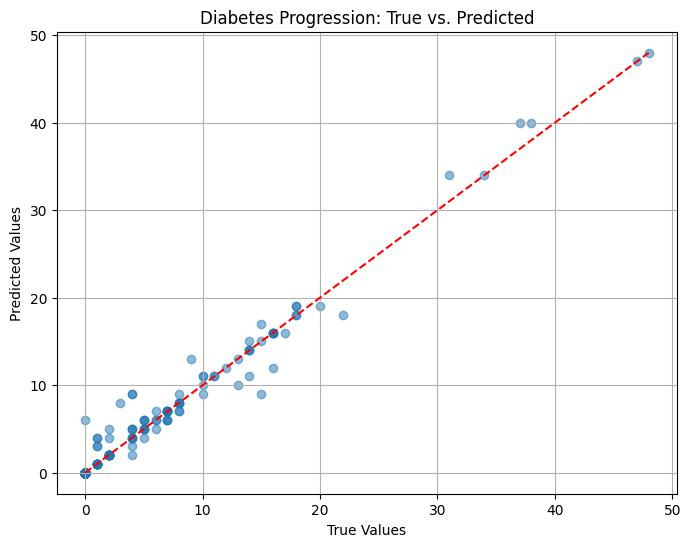

In [188]:
cacuModelEveluator(tpot.predict)

均方误差:测试集 (MSE): 1.19
均方误差:训练集 (MSE): 0.33
决定系数:测试集 (R²): 0.98
决定系数:训练集 (R²): 1.00
绝对误差:测试集 (MAE): 0.39
绝对误差:训练集 (MAE): 0.23
平均绝对百分比误差：测试集 (MAPE): 21.62%
平均绝对百分比误差：训练集 (MAPE): 10.87%


d:\Desktop\Document\Coding\FULL STACK\MCM_Document\mcm-venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Desktop\Document\Coding\FULL STACK\MCM_Document\mcm-venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Desktop\Document\Coding\FULL STACK\MCM_Document\mcm-venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Desktop\Document\Coding\FULL STACK\MCM_Document\mcm-venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Desktop\Document\Coding\FULL STACK\MCM_Document\mcm-venv\Lib\site-packages\sklearn\base.py:493: UserWarning: 

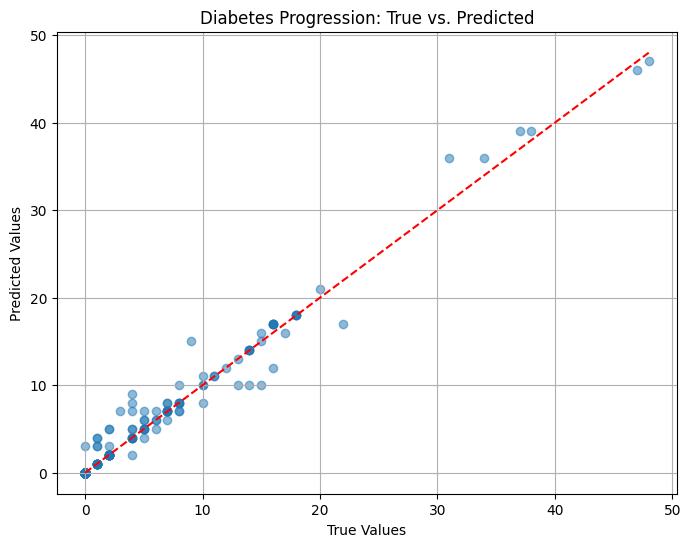

In [189]:
cacuModelEveluator(tpot2.predict)

In [119]:
tpot.export('tpot_exported_pipeline.py')

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_depth=20,
                                       max_features=0.5, min_samples_leaf=2,
                                       min_samples_split=7, n_estimators=200,
                                       random_state=42))])

均方误差:测试集 (MSE): 0.94
均方误差:训练集 (MSE): 0.39
决定系数:测试集 (R²): 0.98
决定系数:训练集 (R²): 0.99
绝对误差:测试集 (MAE): 0.34
绝对误差:训练集 (MAE): 0.24
平均绝对百分比误差：测试集 (MAPE): 16.79%
平均绝对百分比误差：训练集 (MAPE): 11.09%


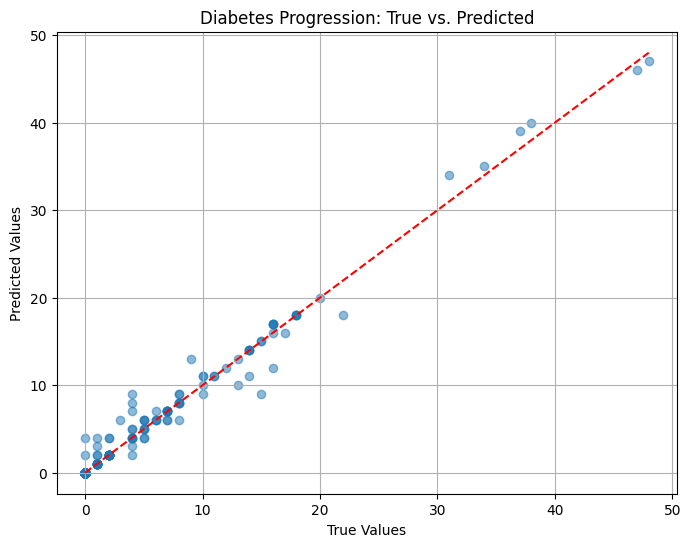

In [236]:
exported_pipeline = make_pipeline(
    # SelectPercentile(score_func=f_regression, percentile=100),
    RandomForestRegressor(bootstrap=False, max_features=0.5, min_samples_leaf=2, min_samples_split=7, n_estimators=200,max_depth=20)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
cacuModelEveluator(exported_pipeline.predict)

C:\Users\GYP\AppData\Local\Temp\ipykernel_23472\3178661953.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(parmars)[sorted_idx])


{'whiskers': [<matplotlib.lines.Line2D at 0x1e5efd936b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e5efd92cf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e5efd93e60>,
 'medians': [<matplotlib.lines.Line2D at 0x1e5efd91cd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e5efd92990>,
 'means': []}

Text(0.5, 0, 'Permutation Importance')

Text(0.5, 1.0, 'Feature Importance via Permutation')

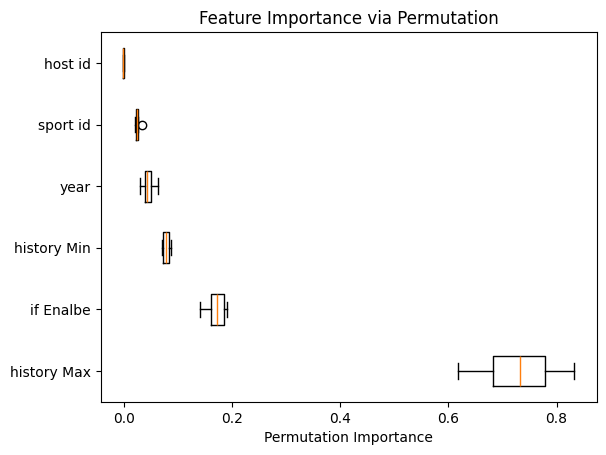

In [237]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    exported_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1]
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(parmars)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.show()

Feature ranking:
1. history Max (0.5715)
2. history Min (0.1923)
3. sport id (0.0940)
4. if Enalbe (0.0928)
5. year (0.0470)
6. host id (0.0025)


<BarContainer object of 6 artists>

([<matplotlib.axis.XTick at 0x1e5e7424ad0>,
 [Text(0, 0, 'history Max'),
  Text(1, 0, 'history Min'),
  Text(2, 0, 'sport id'),
  Text(3, 0, 'if Enalbe'),
  Text(4, 0, 'year'),
  Text(5, 0, 'host id')])

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Importance')

Text(0.5, 1.0, 'Random Forest Feature Importance')

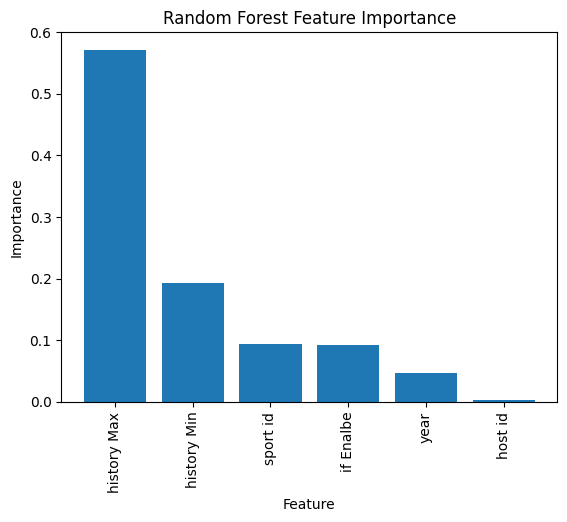

In [238]:
# import shap

rf = exported_pipeline.named_steps['randomforestregressor']
importances = rf.feature_importances_

# 关联特征名称（仅显示被选中的特征）
# selected_importances = np.array(parmars)[importances]
# selected_feature_names = np.array(parmars)[parmars]
feature_names = np.array(parmars)

# 按重要性排序
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]} ({importances[idx]:.4f})")

# 可视化
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# # 提取预处理后的特征数据（确保SHAP分析正确）
# X_processed = exported_pipeline.named_steps['selectpercentile'].transform(X_train)

# # 创建解释器
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_processed)

# # 可视化单个样本的解释
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_processed[0,:], feature_names=selected_feature_names)

# # 特征重要性摘要
# shap.summary_plot(shap_values, X_processed, feature_names=selected_feature_names)

In [186]:
# 获取特征选择器的结果
selected_features = exported_pipeline.named_steps['selectpercentile'].get_support()

# 打印被选中的特征索引
print("Selected feature indices:", np.where(selected_features)[0])

# 如果特征有名称，可以关联名称（假设特征名在feature_names中）
feature_names = parmars[:-1]
selected_feature_names = np.array(feature_names)[selected_features]
print("Selected features:", selected_feature_names)

Selected feature indices: [0 2 3 4 5]
Selected features: ['sport id' 'year' 'history Max' 'history Min' 'if Enalbe']


In [180]:
parmars

['sport id', 'host id', 'year', 'history Max', 'history Min', 'if Enalbe', 'Y']

In [184]:
np.array(feature_names)[[1,2]]

array(['host id', 'year'], dtype='<U11')

In [185]:
selected_features

array([ True, False,  True,  True,  True,  True])

In [ ]:
# 预测2028